In [ ]:
# Performing Necessary library imports
import numpy as np
import scipy as sp
from scipy import optimize
import matplotlib.pyplot as plt

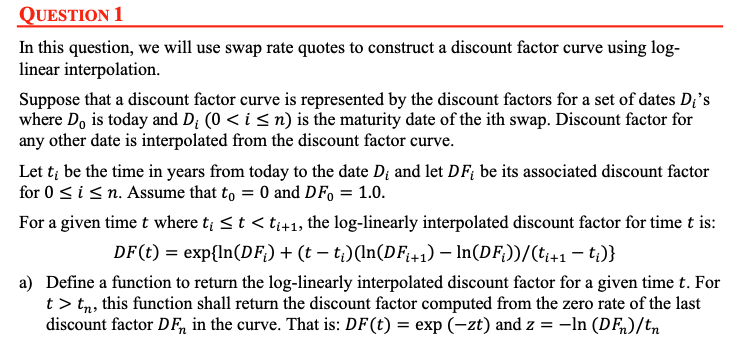

In [ ]:
# Question 1 (a)

'''
A function to return the log-linearly interpolated 
discount factor for a given time 𝑡
'''
def get_df(t, df_times, df_values):

    # if t is less than the smallest element in df_times
    if t < df_times[0]:
        return df_values[0]
    # if t is greater than the largest element in df_times
    elif t > df_times[-1]:
        # calculating df by zero rate of last df
        z = -np.log(df_values[-1]) / df_times[-1]
        df = np.exp(-z * t)
        return df
    # if t is between two elements of df_times
    else:
        # searching for index i where df_times[i] < t < df_times[i+1]
        i = np.searchsorted(df_times, t) - 1
        # calculating df by log-linear interpolation
        df = np.exp(np.log(df_values[i]) + (t - df_times[i]) * 
                    (np.log(df_values[i+1]) - np.log(df_values[i])) / 
                    (df_times[i+1] - df_times[i]))
        return df

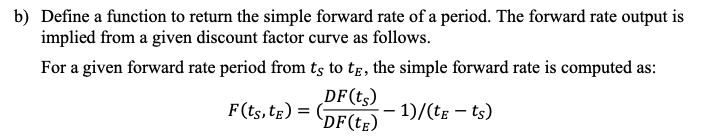

In [ ]:
# Question 1 (b)

'''
A function to return the simple forward rate of a period
'''
def get_forward_rate(t1, t2, df_times, df_values):

  # using get_df to calculate df_s and df_e respectively
  df_t1 = get_df(t1, df_times, df_values)
  df_t2 = get_df(t2, df_times, df_values) 
  
  # calculating forward rate as per given formula
  F = ((df_t1/df_t2) - 1)/(t2 - t1)

  # returning the forward rate
  return F


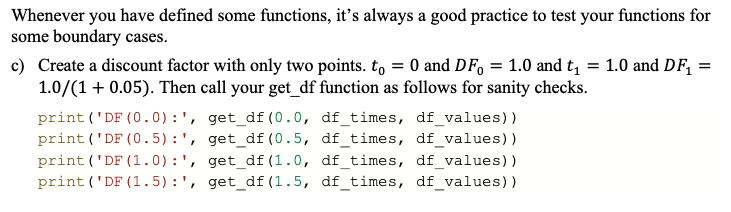

In [ ]:
# Question 1 (c)
df_times = [0.0, 1.0]
df_values = [1.0, 1.0/1.05]
print('DF(0.0):', get_df(0.0, df_times, df_values))
print('DF(0.5):', get_df(0.5, df_times, df_values))
print('DF(1.0):', get_df(1.0, df_times, df_values))
print('DF(1.5):', get_df(1.5, df_times, df_values))

DF(0.0): 1.0
DF(0.5): 0.9759000729485332
DF(1.0): 0.9523809523809523
DF(1.5): 0.9294286409033649


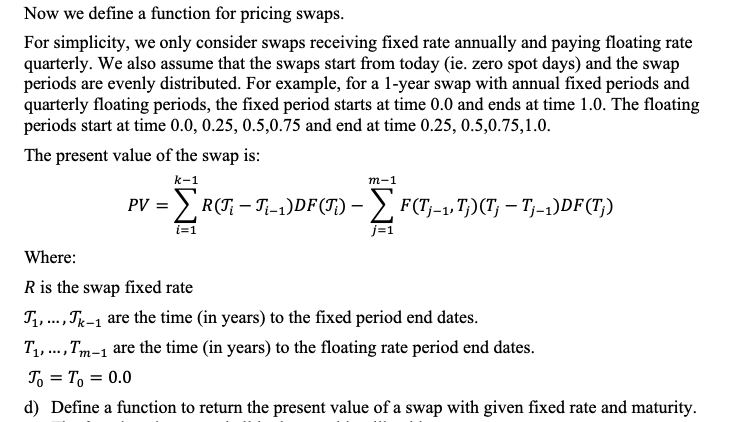

In [ ]:
# Question 1 (d)

'''
A function to return the present value of a swap with given fixed rate and maturity.
'''
def swap_price(rate, maturity, df_times, df_values):
  
  # Making the Tau array with annual increments till maturity
  Tau = [0.0]
  i = 1.0
  mat = maturity
  while mat > 1.0:
    Tau.append(i)
    i += 1
    mat -= 1
  Tau.append(maturity)
  #print(Tau)
  
  # calculating the part of PV stemming from fixed periods
  fixed_part_of_PV = 0
  for i in range(1, len(Tau)):
    fixed_part_of_PV += (rate*(Tau[i] - Tau[i-1])*
                         get_df(Tau[i], df_times, df_values))
  
  # Making the T array with quarterly increments till maturity
  T = [0.0]
  t = maturity
  cur = 0.0
  while t > 0.25:
    t -= 0.25
    cur += 0.25
    T.append(cur)
  T.append(cur + t)
  #print(T)

  # calculating the part of PV stemming from floating periods
  floating_part_of_PV = 0
  for j in range(1, len(T)):
    floating_part_of_PV += (get_forward_rate(T[j-1], T[j], df_times, df_values)*
                            (T[j] - T[j-1])*get_df(T[j], df_times, df_values))

  # calculating the PV to be returned 
  PV = fixed_part_of_PV - floating_part_of_PV

  # returning the PV
  return PV

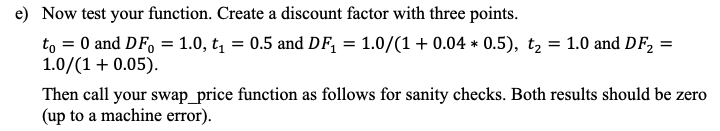

In [ ]:
# Question 1 (e)
df_times = [0.0, 0.5, 1.0]
df_values = [1.0, 1.0/1.02, 1.0/1.05]
print('Swap PV:', swap_price(0.05, 1.0, df_times, df_values)) 
print('Swap PV:', swap_price(0.04, 0.5, df_times, df_values))
print("These results are zero upto a machine error which is a good sanity check!")

Swap PV: -2.0816681711721685e-17
Swap PV: -6.938893903907228e-17
These results are zero upto a machine error which is a good sanity check!


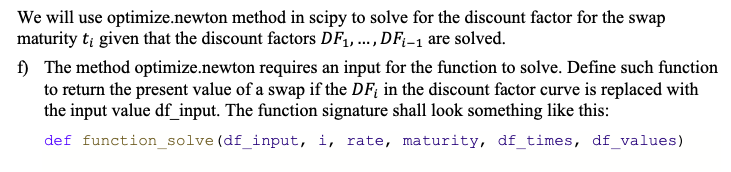

In [ ]:
# Question 1 (f)

'''
A function to return the present value of a swap if the DF_i in the 
discount factor curve is replaced with the input value df_input. 
'''
def function_solve(df_input, i, rate, maturity, df_times, df_values):

  # replacing the discount factor at index i with the input value df_input
  df_values[i] = df_input

  # calling the swap_price function to calculate the present value of the swap
  PV = swap_price(rate, maturity, df_times, df_values)

  # returning the difference between the present value and the target PV
  return PV


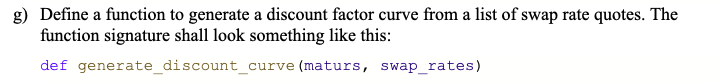

In [ ]:
# Question 1 (g)

'''
A function to generate a discount factor curve from a list of swap rate quotes
'''
def generate_discount_curve(maturs, swap_rates):
  
  # initializing a DF array to store our df values
  DF = [0 for i in range(len(maturs))]

  # for maturity in maturs array we calculate DF
  for i in range(len(maturs)):
      # keeping our df_times updated 
      updated_times = [0] + maturs[:i+1]
      updated_values = [1] + DF[:i+1]
      # solving for the unknown df using numerical newton's method solver
      DF[i] = optimize.newton(function_solve, 0.01, args=(i+1, swap_rates[i], maturs[i], updated_times, updated_values))
  print("The upated times list is: ", updated_times)
  print("The updated values list is: ", updated_values)
  plt.plot(DF, maturs)


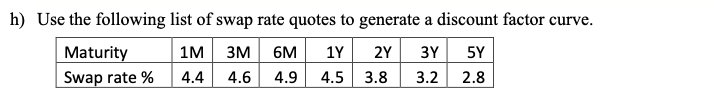

The upated times list is:  [0, 0.08333333333333333, 0.25, 0.5, 1, 2, 3, 5]
The updated values list is:  [1, 0.9963467286615743, 0.9886307464162135, 0.9760858955588092, 0.9569377990430623, 0.9283587318269398, 0.9105334409032555, 0.872336872927112]


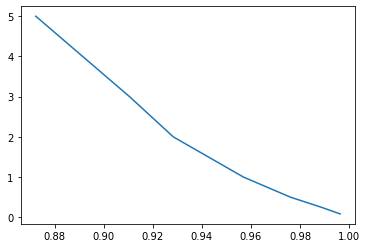

In [ ]:
# Question 1 (h)

# defining the inputs as per the question
maturs = [1/12,3/12,6/12,1,2,3,5]
swap_rates = [4.4/100,4.6/100,4.9/100,4.5/100,3.8/100,3.2/100,2.8/100]
df_times = [0.0, 0.5, 1.0]
df_values = [1.0, 1.0/1.02, 1.0/1.05]

# generating the discount factor curve
generate_discount_curve(maturs,swap_rates)

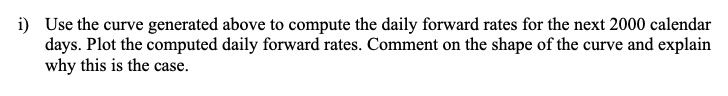

[0.04392217244698404, 0.04392217244698404, 0.043922172446984056, 0.04392217244698403, 0.043922172446984056, 0.043922172446984056, 0.043922172446984, 0.043922172446984056, 0.043922172446984056, 0.043922172446984056, 0.04392217244706505, 0.04392217244698411, 0.043922172446984, 0.043922172446984, 0.04392217244698411, 0.043922172446984, 0.043922172446984, 0.04392217244698411, 0.043922172446984, 0.04392217244698411, 0.043922172446984, 0.043922172446984, 0.043922172446984, 0.04392217244698422, 0.043922172446984, 0.043922172446984, 0.043922172446984, 0.043922172446984, 0.043922172446984, 0.04392217244698422, 0.04551310029336948, 0.04664948157155564, 0.04664948157155564, 0.04664948157155564, 0.04664948157155588, 0.04664948157155564, 0.046649481571474596, 0.04664948157155564, 0.04664948157155564, 0.04664948157155588, 0.046649481571474596, 0.04664948157155564, 0.04664948157155564, 0.04664948157155564, 0.04664948157155588, 0.04664948157155541, 0.04664948157155588, 0.04664948157147483, 0.046649481

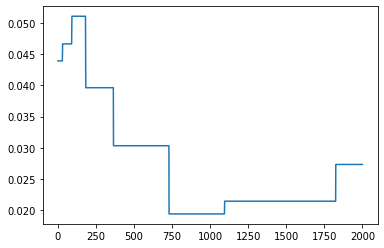

In [ ]:
# Question 1 (i)

# initializing the arrays using the information from part (h)
daily_forward_rates = []
times = []
final_df_times = [0, 0.08333333333333333, 0.25, 0.5, 1, 2, 3, 5]
final_df_values = [1, 0.9963467286615743, 0.9886307464162135, 0.9760858955588092,
                   0.9569377990430623, 0.9283587318269398, 0.9105334409032555,
                   0.872336872927112]

# for each calendar day calculating the daily forward rate and storing it
for i in range(2000):
    daily_forward_rates.append(get_forward_rate(i/365, (i+1)/365, final_df_times, final_df_values))
    times.append(i)

# plotting the daily forward rates vs time (in calendar days)
print(daily_forward_rates)
plt.plot(times, daily_forward_rates)

We can see that initially, the curve of computed daily forward rates is upward-sloping, then it becomes downward-sloping while being flat for some periods. Finally, it is upward-sloping while flat for some time.

*  A downward-sloping forward rate vs. time curve is usually indicative of an environment of declining interest rates. This indicated that the market anticipates that the central bank's monetary policy will ease and interest rates will reduce.

*  A flat forward rate vs. time curve indicates that the market perceives the interest rates as stable and not likely to change soon.

*  An upward-sloping forward rate curve implies that the market expectations for future short-term interest rates increase over time. This may mean a potential future increase in the overall level of interest rates, reflecting higher demand for credit or inflationary pressures in the economy.


